Found 6563 validated image filenames belonging to 38 classes.
Found 2188 validated image filenames belonging to 38 classes.
Found 10547 validated image filenames belonging to 38 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 2176s 11s/step - accuracy: 0.0584 - loss: 9.5649 - val_accuracy: 0.3784 - val_loss: 2.6413
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2174s 11s/step - accuracy: 0.2545 - loss: 5.5905 - val_accuracy: 0.4602 - val_loss: 2.2145
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2174s 11s/step - accuracy: 0.3481 - loss: 4.4237 - val_accuracy: 0.5101 - val_loss: 1.9963
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2203s 11s/step - accuracy: 0.3940 - loss: 3.7610 - val_accuracy: 0.5434 - val_loss: 1.8256
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2175s 11s/step - accuracy: 0.4519 - loss: 3.2399 - val_accuracy: 0.5699 - val_loss: 1.6935
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2179s 11s/step - accuracy: 0.4637 - loss: 3.0199 - val_accuracy: 0.5941 - val_loss: 1.5741
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2172s 11s/step - accuracy: 0.4883 - loss: 2.8087 - val_accuracy: 0.6152 - val_loss: 1.4861
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 2172s 11s/step - accuracy: 0.5073 - loss: 2.6873 - val

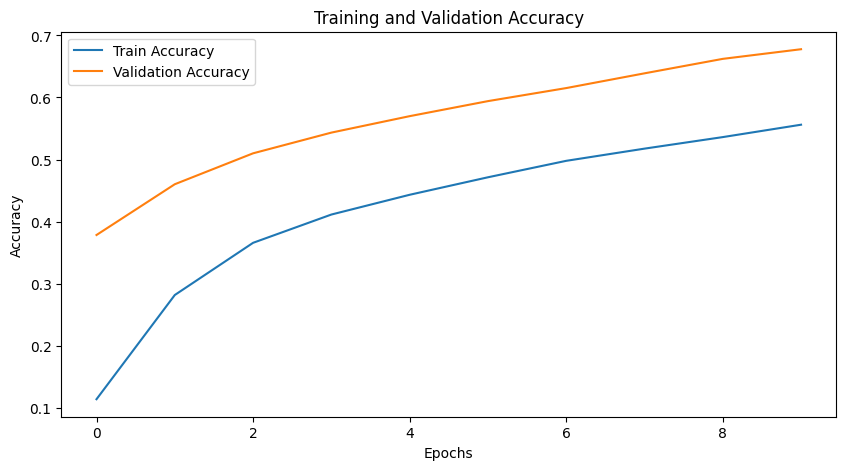

330/330 ━━━━━━━━━━━━━━━━━━━━ 2602s 8s/step


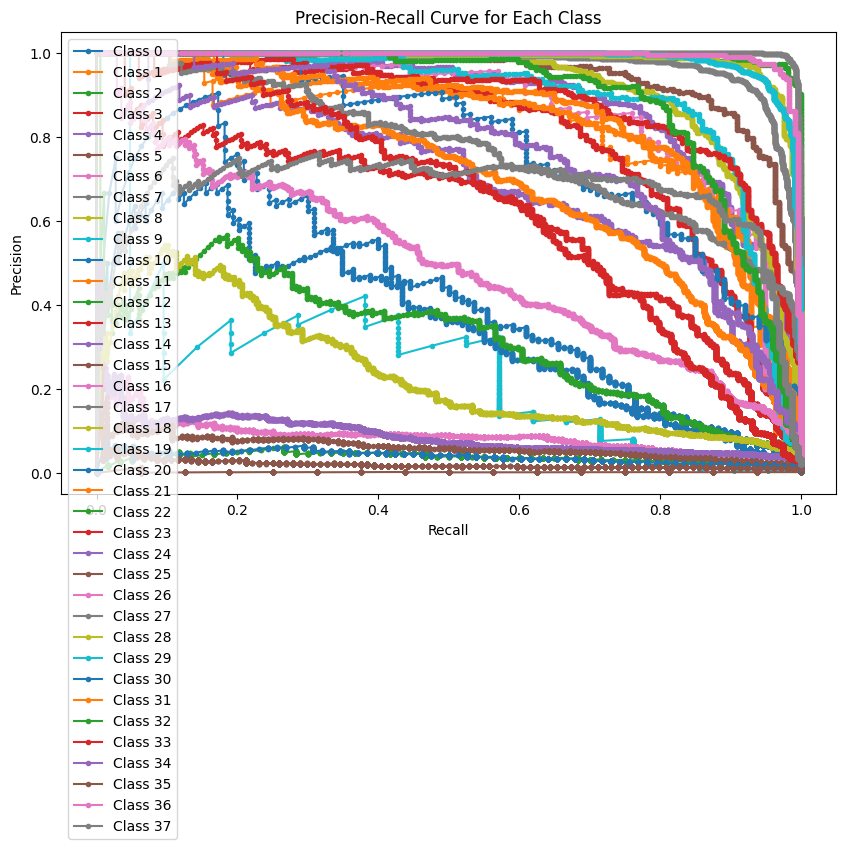

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/plantvillage-dataset/data_distribution_for_SVM"

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

# Collect images and labels from the train folder
train_folder = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split train into 75% training and 25% validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

# Collect images and labels from the test folder
test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# VGG16 expects input images in BGR format and preprocessed with its specific function
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False)

# Define VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(38, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model with slightly lower learning rate for VGG16
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight_dict
)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
y_true = tf.keras.utils.to_categorical(test_gen.classes, 38)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()